In [1]:
import random
import os
import time
import gc 
from collections import defaultdict

from matplotlib import pyplot as plt
from IPython import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, RandomSampler
import numpy as np
from scipy.optimize import linear_sum_assignment
import torchvision
from torchvision.ops import box_convert, generalized_box_iou
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
import timm
from timm.layers import resample_abs_pos_embed 
from tqdm.auto import tqdm
from pprint import pformat
from torchmetrics.detection.mean_ap import MeanAveragePrecision

=from dl_toolbox.transforms import NormalizeBB






In [2]:


@torch.no_grad()
#def hungarian_matching(pred_cls, pred_boxes, target_cls, target_boxes):
def hungarian_matching(pred_logits, pred_boxes, tgt_cls, tgt_boxes):
    """ 
    Params:
        pred_cls: Tensor of dim [B, num_queries, num_classes] with the class logits
        pred_boxes: Tensor of dim [B, num_queries, 4] with the pred box coord
        target_cls: list (len=batchsize) of Tensors of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth objects in the target) containing the class labels
        target_boxes: list (len=batchsize) of Tensors of dim [num_target_boxes, 4] containing the target box coord

    Returns:
        A list of size batch_size, containing tuples of (index_i, index_j) where:
            - index_i is the indices of the selected predictions (in order)
            - index_j is the indices of the corresponding selected targets (in order)
        For each batch element, it holds:
            len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
    """
    
    # Also concat the target labels and boxes
    tgt_ids = torch.cat(tgt_cls)
    tgt_bbox = torch.cat(tgt_boxes)
    
    # For each query box in the batch, the output proba of all classes
    all_query_probs = pred_logits.flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
    # Compute the classification cost. Contrary to the loss, we don't use the NLL,
    # but approximate it in 1 - proba[target class].
    # The 1 is a constant that doesn't change the matching, it can be ommitted.
    # For each query box in the batch, the output prob of the classes of all targets of the batch
    cost_class = -all_query_probs[:, tgt_ids] # bs*num_q x tot num targets over batch

    # Compute the L1 cost between boxes
    out_bbox = pred_boxes.flatten(0, 1)  # [batch_size * num_queries, 4]
    cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1) # bs*num_q x tot num targets over batch

    # Compute the giou cost betwen boxes
    out_bbox = box_convert(out_bbox, 'cxcywh', 'xyxy')
    tgt_bbox = box_convert(tgt_bbox, 'cxcywh', 'xyxy')
    cost_giou = -generalized_box_iou(out_bbox, tgt_bbox)

    # Final cost matrix
    C = 5 * cost_bbox + cost_class + 2 * cost_giou
    B, Q = pred_logits.shape[:2]
    C = C.view(B, Q, -1).cpu() # bs x num_q x tot num targets over batch

    sizes = [len(bbox) for bbox in tgt_boxes] # num_tgt per img 

    # Finds the minimum cost detection token/target assignment per img
    indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
    int64 = lambda x: torch.as_tensor(x, dtype=torch.int64)
    return [(int64(i), int64(j)) for i, j in indices]

In [3]:

class SetCriterion(nn.Module):
    def __init__(self, num_classes, eos_coef):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            eos_coef: relative classification weight applied to the no-object category
        """
        super().__init__()
        self.num_classes = num_classes
        self.eos_coef = eos_coef
        self.weight_dict = {
            'loss_ce': 1,
            'loss_bbox': 5,
            'loss_giou': 2
        }
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, pred_logits, tgt_cls, matches):
        """
        Params:
            matches: list of batch_size pairs (I, J) of arrays such that output bbox I[n] must be matched with target bbox J[n]
        """
                
        # all N tgt labels are reordered following the matches and concatenated  
        reordered_labels = [t[J] for t, (_, J) in zip(tgt_cls, matches)]
        reordered_labels = torch.cat(reordered_labels) # Nx1
        #print(f'{reordered_labels.shape =}')
        
        # batch_idxs[i] is the idx in the batch of the img to which the i-th elem in the new order corresponds
        batch_idxs = [torch.full_like(pred, i) for i, (pred, _) in enumerate(matches)]
        batch_idxs = torch.cat(batch_idxs) # Nx1
        
        # src_idxs[i] is the idx of the preds for img batch_idxs[i] to which the i-th elem in the new order corresponds
        pred_idxs = torch.cat([pred for (pred, _) in matches]) # Nx1
        
        # target_classes is of shape batch_size x num det tokens, and is num_classes (=no_obj) everywhere, except for each token that is matched to a tgt, where it is the label of the matched tgt
        target_classes = torch.full(
            pred_logits.shape[:2], #BxNdetTok
            self.num_classes, #Filled with num_cls
            dtype=torch.int64, 
            device=pred_logits.device
        )
        target_classes[(batch_idxs, pred_idxs)] = reordered_labels
        loss_ce = nn.functional.cross_entropy(
            pred_logits.transpose(1, 2), #BxNclsxd1xd2...
            target_classes, #Bxd1xd2...
            self.empty_weight
        )
        
        ## If we did as follows, then there would be no incentive for the network to output small logits for non-matched tokens
        #reordered_pred_logits = pred_logits[(batch_idxs, pred_idxs)] # NxNcls
        #other_loss_ce = F.cross_entropy(
        #    reordered_pred_logits,
        #    reordered_labels
        #)
        
        losses = {'loss_ce': loss_ce}
        return losses

    def loss_boxes(self, pred_boxes, tgt_boxes, matches, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
        """
        reordered_target_boxes = [t[i] for t, (_, i) in zip(tgt_boxes, matches)]
        reordered_target_boxes = torch.cat(reordered_target_boxes) # Nx4
        #print(f'{reordered_target_boxes.shape =}')
        
        # batch_idxs[i] is the idx in the batch of the img to which the i-th elem in the new order corresponds
        batch_idxs = [torch.full_like(pred, i) for i, (pred, _) in enumerate(matches)]
        batch_idxs = torch.cat(batch_idxs) # Nx1
        
        # src_idxs[i] is the idx of the preds for img batch_idxs[i] to which the i-th elem in the new order corresponds
        pred_idxs = torch.cat([pred for (pred, _) in matches]) # Nx1
        
        #print(f'{pred_boxes.shape =}')
        reordered_pred_boxes = pred_boxes[(batch_idxs, pred_idxs)] # Nx4
        #print(f'{reordered_pred_boxes.shape =}')

        losses = {}
        loss_bbox = nn.functional.l1_loss(
            reordered_pred_boxes,
            reordered_target_boxes,
            reduction='none'
        )
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes
        loss_giou = 1 - torch.diag(generalized_box_iou(
            box_convert(reordered_pred_boxes, 'cxcywh', 'xyxy'),
            box_convert(reordered_target_boxes, 'cxcywh', 'xyxy')))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def forward(self, pred_logits, pred_boxes, tgt_cls, tgt_boxes, matches):
        """ This performs the loss computation.
        Parameters:
            outputs: dict of tensors, see the output specification of the model for the format
            targets: list of dicts, such that len(targets) == batch_size. The expected keys in each dict depends on the losses applied, see each loss' doc
            matches: list of batch_size pairs (I, J) of arrays such that for pair (I,J) output bbox I[n] must be matched with target bbox J[n]
        """
        # Compute the average (?) number of target boxes accross all nodes, for normalization purposes
        #num_boxes = sum(len(boxes) for boxes in tgt_boxes)
        #device = next(iter(outputs.values())).device
        #num_boxes = torch.as_tensor(
        #    [num_boxes],
        #    dtype=torch.float,
        #    device=device
        #)
        num_boxes = sum(len(boxes) for boxes in tgt_boxes)
        # Compute all the requested losses
        losses = {}
        losses.update(self.loss_labels(pred_logits, tgt_cls, matches))
        losses.update(self.loss_boxes(pred_boxes, tgt_boxes, matches, float(num_boxes)))
        losses['combined_loss'] = sum(losses[k] * self.weight_dict[k] for k in losses.keys() if k in self.weight_dict)
        return losses   

In [4]:
@torch.no_grad()
def post_process(pred_logits, pred_boxes, size):
    prob = nn.functional.softmax(pred_logits, -1) # bxNdetTokxNcls
    # Most prob cls (except no-obj: NOOBJ is class Ncls ?) and its score per img per token
    scores, labels = prob[..., :-1].max(-1) # bxNdetTok
    
    #pred_boxes = box_convert(pred_boxes, 'cxcywh', 'xyxy')
    # and from relative [0, 1] to absolute [0, height] coordinates
    #img_h, img_w = target_sizes.unbind(1)
    #scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
    h,w = size
    scale_fct = torch.tensor([w, h, w, h], device=pred_boxes.device)
    boxes = pred_boxes * scale_fct[None, None, :]

    results = [{'scores': s, 'labels': l, 'boxes': b}
               for s, l, b in zip(scores, labels, boxes)]
    return results

In [5]:
 


class Detector(nn.Module):
    def __init__(self, num_classes, det_token_num=100):
        super().__init__()
        self.det_token_num = det_token_num
        self.num_classes = num_classes
        #self.backbone, hidden_dim = small(pretrained=pre_trained)   
        
        self.backbone = timm.create_model(
            'vit_tiny_patch16_224',
            pretrained=True,
            dynamic_img_size=True #Deals with inputs of other size than pretraining
        )
        self.embed_dim = self.backbone.embed_dim 
        
        self.finetune_det()
        #self.class_embed = MLP(hidden_dim, hidden_dim, num_classes + 1, 3)
        #self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.class_embed = torchvision.ops.MLP(
            self.embed_dim,
            [self.embed_dim, self.embed_dim, self.num_classes+1]
        ) #Num_classes + 1 to deal with no_obj category
        self.bbox_embed = torchvision.ops.MLP(
            self.embed_dim,
            [self.embed_dim, self.embed_dim, 4]
        )
        
    def finetune_det(self):

         #import math
         #g = math.pow(self.backbone.pos_embed.size(1) - 1, 0.5)
         #if int(g) - g != 0:
         #    self.backbone.pos_embed = torch.nn.Parameter(self.backbone.pos_embed[:, 1:, :])

        #self.backbone.det_token_num = self.det_token_num
        
        self.det_token = nn.Parameter(torch.zeros(1, self.det_token_num, self.embed_dim))
        self.det_token = nn.init.trunc_normal_(self.det_token, std=.02)
        
        #self.cls_pos_embed = nn.Parameter(self.backbone.pos_embed[:, 0, :][:,None])
        
        self.det_pos_embed = nn.Parameter(torch.zeros(1, self.det_token_num, self.embed_dim))
        self.det_pos_embed = nn.init.trunc_normal_(self.det_pos_embed, std=.02)
        
        #patch_pos_embed = self.backbone.pos_embed[:, 1:, :]
        #patch_pos_embed = patch_pos_embed.transpose(1,2)
        #B, E, Q = patch_pos_embed.shape
        #P_H, P_W = self.backbone.img_size[0] // self.backbone.patch_size, self.backbone.img_size[1] // self.backbone.patch_size
        #patch_pos_embed = patch_pos_embed.view(B, E, P_H, P_W)
        #H, W = img_size
        #new_P_H, new_P_W = H//self.backbone.patch_size, W//self.backbone.patch_size
        #patch_pos_embed = nn.functional.interpolate(patch_pos_embed, size=(new_P_H,new_P_W), mode='bicubic', align_corners=False)
        #self.patch_pos_embed = nn.Parameter(patch_pos_embed.flatten(2).transpose(1, 2))
        
        #self.backbone.pos_embed = torch.nn.Parameter(torch.cat((cls_pos_embed, patch_pos_embed, det_pos_embed), dim=1))
        
        #self.backbone.img_size = img_size
        #self.backbone.has_mid_pe = False
        #self.backbone.use_checkpoint=False
        
        self.backbone.num_prefix_tokens += self.det_token_num
        
    #def forward_features(self, x):
    #    B, H, W = x.shape[0], x.shape[2], x.shape[3]
#
    #    x = self.backbone.patch_embed(x)
    #    temp_pos_embed = torch.cat((self.cls_pos_embed, self.patch_pos_embed, self.det_pos_embed), dim=1)
    #    # interpolate init pe
    #    if (temp_pos_embed.shape[1] - 1 - self.det_token_num) != x.shape[1]:
    #        temp_pos_embed = self.backbone.InterpolateInitPosEmbed(temp_pos_embed, img_size=(H,W))
#
    #    cls_tokens = self.backbone.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
    #    det_token = self.det_token.expand(B, -1, -1)
    #    x = torch.cat((cls_tokens, x, det_token), dim=1)
    #    x = x + temp_pos_embed
    #    x = self.backbone.pos_drop(x)
#
    #    for i in range(len((self.backbone.blocks))):
    #        x = self.backbone.blocks[i](x)
    #    x = self.backbone.norm(x)
#
    #    return x[:, -self.det_token_num:, :]
    #
    #def forward(self, samples: NestedTensor):
    #    # import pdb;pdb.set_trace()
    #    if isinstance(samples, (list, torch.Tensor)):
    #        samples = nested_tensor_from_tensor_list(samples)
    #    x = self.forward_features(samples.tensors)
    #    # x = x[:, 1:,:]
    #    outputs_class = self.class_embed(x)
    #    outputs_coord = self.bbox_embed(x).sigmoid()
    #    out = {'pred_logits': outputs_class, 'pred_boxes': outputs_coord}
    #    return out
    
    def forward(self, x):
        """ This code relies on class_token=True in ViT
        """
        x = self.backbone.patch_embed(x)
        
        # Inserting position embedding for detection tokens and resampling if dynamic
        cls_pos_embed = self.backbone.pos_embed[:, 0, :][:,None] # size 1x1xembed_dim
        patch_pos_embed = self.backbone.pos_embed[:, 1:, :] # 1xnum_patchxembed_dim
        pos_embed = torch.cat((self.det_pos_embed, cls_pos_embed, patch_pos_embed), dim=1)
        if self.backbone.dynamic_img_size:
            B, H, W, C = x.shape
            pos_embed = resample_abs_pos_embed(
                pos_embed,
                (H, W),
                num_prefix_tokens=self.backbone.num_prefix_tokens,
            )
            x = x.view(B, -1, C)
            
        # Inserting detection tokens    
        cls_token = self.backbone.cls_token.expand(x.shape[0], -1, -1) 
        det_token = self.det_token.expand(x.shape[0], -1, -1)
        x = torch.cat([det_token, cls_token, x], dim=1)
        
        # Forward ViT
        x += pos_embed
        x = self.backbone.pos_drop(x)
        x = self.backbone.patch_drop(x)
        x = self.backbone.norm_pre(x)
        x = self.backbone.blocks(x)
        x = self.backbone.norm(x)
        
        # Extracting processed detection tokens + forward heads
        x = x[:,:self.det_token_num,...]
        pred_logits = self.class_embed(x)
        pred_boxes = self.bbox_embed(x).sigmoid()
        
        return pred_logits, pred_boxes

/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
num_classes = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Detector(
    num_classes=num_classes,
    #pre_trained='/d/pfournie/YOLOS/deit_small_patch16_224-cd65a155.pth',
    det_token_num=100,
    #backbone_name='small',
    #init_pe_size=(560,560)
)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
nb_tot = sum([int(torch.numel(p)) for p in model.parameters()])
print(f"Training {n_parameters} params out of {nb_tot}")
model.to(device)

criterion = SetCriterion(num_classes, eos_coef=0.1)
criterion.to(device)

Training 5905198 params out of 5905198


SetCriterion()

In [7]:
def build_optimizer(model, lr):
    if hasattr(model.backbone, 'no_weight_decay'):
        skip = model.backbone.no_weight_decay()
    head = []
    backbone_decay = []
    backbone_no_decay = []
    for name, param in model.named_parameters():
        if "backbone" not in name and param.requires_grad:
            print(f"{name} in head")
            head.append(param)
        if "backbone" in name and param.requires_grad:
            #print(f'{name} in backbone')
            if len(param.shape) == 1 or name.endswith(".bias") or name.split('.')[-1] in skip:
                backbone_no_decay.append(param)
            else:
                backbone_decay.append(param)
    param_dicts = [
        {"params": head, "lr": lr},
        {"params": backbone_no_decay, "weight_decay": 0., "lr": lr/100.},
        {"params": backbone_decay, "lr": lr/100.},
    ]
    optimizer = torch.optim.AdamW(param_dicts, weight_decay=0.0001)
    return optimizer

optimizer = build_optimizer(model, lr=0.0001)

det_token in head
det_pos_embed in head
class_embed.0.weight in head
class_embed.0.bias in head
class_embed.3.weight in head
class_embed.3.bias in head
class_embed.6.weight in head
class_embed.6.bias in head
bbox_embed.0.weight in head
bbox_embed.0.bias in head
bbox_embed.3.weight in head
bbox_embed.3.bias in head
bbox_embed.6.weight in head
bbox_embed.6.bias in head


### Dataset & dataloaders

In [8]:


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class: attention différent de fcos, A UNIFORMISER
        labels = torch.zeros((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        h, w = T.functional.get_size(img)
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=(h,w))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = torch.Tensor([image_id])
        #target["area"] = area
        #target["iscrowd"] = iscrowd
        target["orig_size"] = torch.as_tensor([int(h), int(w)])
        target["size"] = torch.as_tensor([int(h), int(w)])

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return {'image': img, 'target': target}
    
    def __len__(self):
        return len(self.imgs)


tf = T.Compose(
    [
        T.Resize(size=480, max_size=560),
        T.RandomCrop(size=(560,560), pad_if_needed=True, fill=0),
        T.ToDtype(torch.float, scale=True),
        T.SanitizeBoundingBoxes(),
        T.ConvertBoundingBoxFormat(format='CXCYWH'),
        NormalizeBB(),
        #T.ToPureTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)


dataset = PennFudanDataset('/data/PennFudanPed', tf)
dataset_test = PennFudanDataset('/data/PennFudanPed', tf)
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
train_set = torch.utils.data.Subset(dataset, indices[:-50])
val_set = torch.utils.data.Subset(dataset_test, indices[-50:])


def list_of_dicts_to_dict_of_lists(list_of_dicts):
    dict_of_lists = defaultdict(list)
    for dct in list_of_dicts:
        for key, value in dct.items():
            dict_of_lists[key].append(value)
    res = dict(dict_of_lists)
    return res

def collate(batch):
    batch = list_of_dicts_to_dict_of_lists(batch)
    batch['image'] = torch.stack(batch['image'])
    return batch

train_dataloader = DataLoader(
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    dataset=train_set,
    sampler=RandomSampler(
        train_set,
        #replacement=True,
        #num_samples=100*2
    ),
    drop_last=True,
    collate_fn=collate
)

val_dataloader = DataLoader(
    batch_size=4,
    num_workers=4,
    pin_memory=False,
    dataset=val_set,
    shuffle=False,
    drop_last=False,
    collate_fn=collate
)

In [9]:
#lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#    optimizer=optimizer,
#    start_factor=1.,
#    end_factor=0.01,
#    total_iters=150*30
#)
#
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_dataloader),
    epochs=150
)

In [10]:
def unnorm_bounding_boxes(inpt):
    bounding_boxes = inpt.as_subclass(torch.Tensor)
    in_dtype = bounding_boxes.dtype
    bounding_boxes = bounding_boxes.clone() if bounding_boxes.is_floating_point() else bounding_boxes.float()
    whwh = torch.Tensor(inpt.canvas_size).repeat(2).flip(dims=(0,)).to(inpt.device) # canvas_size is H,W hence the flip to WHWH
    out_boxes = bounding_boxes*whwh 
    return tv_tensors.wrap(out_boxes.to(in_dtype), like=inpt)

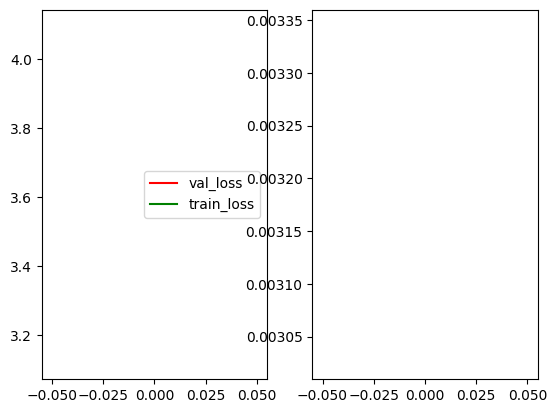

[3.9999999999999996e-05, 3.9999999999999996e-05, 3.9999999999999996e-05]


 60%|████████████████████████████████████████████████████████████████████████                                                | 18/30 [00:02<00:01,  6.67it/s]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc7be446790> (for post_execute):



KeyboardInterrupt



In [11]:


gc.collect()
#torch.cuda.empty_cache()
gc.collect()

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

epochs = []
valid_losses = []
train_losses = []
valid_map = []

fig, axes = plt.subplots(1,2)
dh = display.display(fig, display_id=True)
print(lr_scheduler.get_last_lr())
for epoch in range(150):
    epochs.append(epoch)
    time_ep = time.time()
    
    valid_loss = 0
    valid_bbox_loss = 0
    valid_giou_loss = 0
    valid_ce_loss = 0
    model.eval()
    criterion.eval()
    with torch.no_grad():
        map_metric = MeanAveragePrecision(
            box_format='cxcywh', # make sure your dataset outputs target in xywh format
            backend='faster_coco_eval'
        )
        for batch in tqdm(val_dataloader):
            image = batch["image"].to(device)
            targets = batch['target']
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            pred_logits, pred_boxes = model(image)
            
            matches = hungarian_matching(
                pred_logits,
                pred_boxes,
                tgt_cls=[tgt["labels"] for tgt in targets],
                tgt_boxes=[tgt["boxes"] for tgt in targets]
            )
            loss_dict = criterion(
                pred_logits,
                pred_boxes,
                tgt_cls=[tgt["labels"] for tgt in targets],
                tgt_boxes=[tgt["boxes"] for tgt in targets],
                matches=matches
            )
            loss = loss_dict['combined_loss']
            
            b,c,h,w = image.shape
            results = post_process(
                pred_logits,
                pred_boxes,
                size=(h,w)
            )
            for t in targets:
                t['boxes'] = unnorm_bounding_boxes(t['boxes'])
            map_metric.update(results, targets)
            
            valid_loss += loss.detach().item()
            valid_bbox_loss += loss_dict["loss_bbox"].detach().item()
            valid_giou_loss += loss_dict["loss_giou"].detach().item()
            valid_ce_loss += loss_dict["loss_ce"].detach().item()
        valid_loss /= len(val_dataloader)
        valid_bbox_loss /= len(val_dataloader)
        valid_giou_loss /= len(val_dataloader)
        valid_ce_loss /= len(val_dataloader)
        mapmetrics = map_metric.compute()
        #print(f"{epoch = }")
        #print(f"{valid_loss = }")
        #print(f"{valid_bbox_loss = }")
        #print(f"{valid_giou_loss = }")
        #print(f"{valid_ce_loss = }")
        #print(pformat(mapmetrics))
        valid_losses.append(valid_loss)
        valid_map.append(mapmetrics['map'])
        map_metric.reset()
        
    train_loss = 0
    train_bbox_loss = 0
    train_giou_loss = 0
    train_ce_loss = 0
    model.train()
    criterion.train()
    for batch in tqdm(train_dataloader):
        image = batch["image"].to(device)
        pred_logits, pred_boxes = model(image)
        targets = batch['target']
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        matches = hungarian_matching(
            pred_logits,
            pred_boxes,
            tgt_cls=[tgt["labels"] for tgt in targets],
            tgt_boxes=[tgt["boxes"] for tgt in targets]
        )
        loss_dict = criterion(
            pred_logits,
            pred_boxes,
            tgt_cls=[tgt["labels"] for tgt in targets],
            tgt_boxes=[tgt["boxes"] for tgt in targets],
            matches=matches
        )
        loss = loss_dict['combined_loss']
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        lr_scheduler.step()
        train_loss += loss.detach().item()
        train_bbox_loss += loss_dict["loss_bbox"].detach().item()
        train_giou_loss += loss_dict["loss_giou"].detach().item()
        train_ce_loss += loss_dict["loss_ce"].detach().item()
    train_loss /= len(train_dataloader)
    train_bbox_loss /= len(train_dataloader)
    train_giou_loss /= len(train_dataloader)
    train_ce_loss /= len(train_dataloader)
    #print(f"{epoch = }")
    #print(f"lr = {lr_scheduler.get_last_lr()[0]}"),
    #print(f"{train_loss = }")
    #print(f"{train_bbox_loss = }")
    #print(f"{train_giou_loss = }")
    #print(f"{train_ce_loss = }")
    #lr_scheduler.step(epoch)
    train_losses.append(train_loss)
    axes[0].plot(epochs, valid_losses, 'r', label='val_loss')
    axes[0].plot(epochs, train_losses, 'g', label='train_loss')
    axes[1].plot(epochs, valid_map, 'b', label='map')
    if epoch==0: axes[0].legend()
    dh.update(fig)
    time_ep = time.time() - time_ep
plt.close()